In [1]:
import numpy as np
import matplotlib.pyplot as plt
from gekko import GEKKO

In [2]:
# create GEKKO model
m = GEKKO()

In [35]:
import numpy as np
from gekko import GEKKO
import matplotlib.pyplot as plt

m = GEKKO()

nt = 101
tm = np.linspace(0,1,nt)
m.time = tm

distance = 1000

# constants
sm = 39.0 #maximal VO2
e0 = 2200 #starting level of energy
e_crit = 0.15 * e0 #critical level of energy, when sigma decreases
g = 9.81 #gravitational constant

# sigma data to create spline
E_data = np.linspace(0, e0, 1001)
sigma_data = sm * E_data/(e0 * e_crit) + 0.75 * sm * (1 - E_data/(e0 * e_crit))
sigma_data[E_data > e_crit] = sm

# sigma data to create spline
x_data = np.linspace(0, distance, 500)
slope_data = np.array(250*[1/18 * np.pi] + 250 * [-1/18 * np.pi])

# Variables
v = m.Var(value=0.0, lb=0.0, ub=10.0)
E = m.Var(value=e0, lb=0.0)
x = m.Var(value=0.0)
sigma = m.Var(value=sm, lb=0)
sigma_max = m.Var()
slope = m.Var(value=slope_data[0])

p = np.zeros(nt)
p[-1] = 1.0
final = m.Param(value=p)

# FV
tf = m.FV(value=150.0,lb=0.1,ub=300.0)
tf.STATUS = 1

# MV
u = m.MV(value=0,lb=0,ub=12)
u.STATUS = 1

# energy decrease at the end
m.cspline(E, sigma_max, E_data, sigma_data, True)

# slope
m.cspline(x, slope, x_data, slope_data, True)

m.Equation(v.dt()==(u - g * m.sin(slope) - v/0.892)*tf)
m.Equation(E.dt()==(sigma - u*v)*tf)
m.Equation(x.dt()==(v*m.cos(slope))*tf)
m.Equation(sigma<=sigma_max)

m.Equation((distance-x)*final<=0)

m.Minimize(tf)

m.options.IMODE = 6
m.options.MAX_ITER=1000
m.solve()

print('Final Time: ' + str(tf.value[0]))

tm = tm * tf.value[0]

apm 90.156.80.122_gk_model6 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            2
   Constants    :            0
   Variables    :           11
   Intermediates:            0
   Connections  :            4
   Equations    :            6
   Residuals    :            6
 
 Number of state variables:           1601
 Number of total equations: -         1400
 Number of slack variables: -          200
 ---------------------------------------
 Degrees of freedom       :              1
 
 **********************************************
 Dynamic Control with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This program contains Ipop

  79  1.5839722e+04 1.09e+00 1.44e+04  -3.4 1.61e+01  -3.0 1.00e+00 2.09e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80  1.5825229e+04 1.11e+00 1.00e+04  -9.4 1.90e+01  -3.4 7.11e-02 1.36e-01h  1
  81  1.5942592e+04 5.85e+00 1.47e-01  -2.5 6.93e+00  -3.9 1.00e+00 1.00e+00f  1
  82  1.7718003e+04 2.71e+02 1.90e+06  -0.5 1.95e+06    -  1.21e-02 6.73e-02f  1
  83  1.6293681e+04 4.40e+02 1.11e+06  -1.9 3.54e+05    -  3.37e-01 4.33e-01f  1
  84  1.5770887e+04 1.16e+03 2.63e+05  -1.9 4.28e+04    -  4.28e-01 8.69e-01h  1
  85  1.5560051e+04 1.28e+03 2.78e+00  -2.1 2.02e+04    -  1.00e+00 1.00e+00h  1
  86  1.5397389e+04 9.13e+01 3.86e+04  -2.5 1.82e+04    -  9.17e-01 1.00e+00h  1
  87  1.5235250e+04 2.58e+01 1.11e-02  -3.0 2.35e+04    -  1.00e+00 1.00e+00h  1
  88  1.5223788e+04 1.74e-02 3.43e-04  -4.2 1.06e+00  -4.4 1.00e+00 1.00e+00h  1
  89  1.5222566e+04 6.24e-02 4.41e+01  -6.3 2.66e+00  -4.9 9.93e-01 1.00e+00h  1
iter    objective    inf_pr 

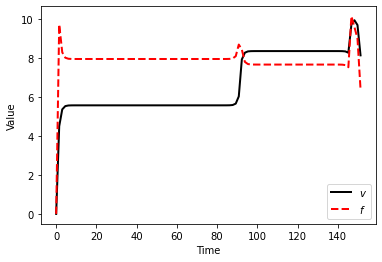

In [36]:
plt.figure(1)
plt.plot(tm,v.value,'k-',lw=2,label=r'$v$')
plt.plot(tm,u.value,'r--',lw=2,label=r'$f$')
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

In [ ]:
# nutrition depends on distance x
# oxidation rate - somehow based on v?